In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display

In [2]:
from cycler import cycler
defcyc = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
                          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#808000'])
plt.rc('axes', prop_cycle=defcyc)

## Embedding Utility functions

In [3]:
def load_embeddings(filename):
    ret = {}
    with open(filename , 'r') as f:
        for line in f.readlines():
            tokens = line.split()
            word , vec = tokens[0] , list(map(float , tokens[1:]))
            ret[word] = np.array(vec)
    return ret

def load_words(filename):
    # load the words to embed from the text file
    ret = []
    with open(filename , 'r') as f:
        for line in f.readlines():
            ret.append(line.strip())
    return ret

def get_embedding(embeddings_dict , word):
    # if the word consists of multiple tokens, average the vectors
    num_tokens = 0
    vecs = []
    for tok in word.split():
        num_tokens += 1
        vecs.append(embeddings_dict[tok.lower()])
    ret = np.mean(np.vstack(vecs) , axis = 0)
    #ret /= np.linalg.norm(ret)
    
    return ret
    

## Loading Embeddings

In [4]:
embeddings = load_embeddings("glove100.txt")
words = load_words("words.txt")

## Embedding the words

In [5]:
arr = []
for word in words:
    arr.append(get_embedding(embeddings , word))
X = np.vstack(arr)
X.shape

(31, 100)

## Visualization function

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize(embeddings , words):
    fig , ax = plt.subplots(1, 1, figsize=(12,8))
    assert len(embeddings) == len(words)
    for pt , word in zip(embeddings , words):
        ax.scatter(pt[0] , pt[1])
        ax.annotate(word , (pt[0] , pt[1]))
    ax.set_prop_cycle(defcyc)

### PCA embeddings

The results look ok. However I think there could be an issue, embedding a small set of words using PCA may not give a good representation, because this small sample of words may not represent the real variance that exists in the original population. This may lead into putting close words far apart from each other because of the sample variance. At the same time, fitting the PCA embedder on the whole word2vec embeddings isn't good.

In [7]:
pca_embeddings = PCA(n_components=2).fit_transform(X)

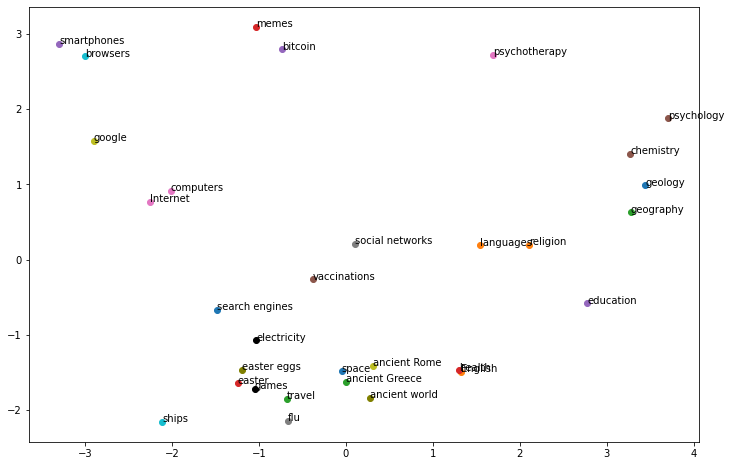

In [8]:
visualize(pca_embeddings , words)

### TSNE
I think tsne embeddings are much better because of the fact I mentioned above. tsne doesn't get affected by the sampling variance. It uses each word coordinates in the hyperspace and build a probability distribution over the neigbours. So their distance in the hyperspace is the key decider.

Instances of the words being placed far apart in PCA could be seen, some of them are: (psychology,psychotherapy) , (English, Languages) ...

For me simply the eye-test and this basic reasoning about the mechanics of PCA/Tsne makes tsne the better choice for me.


In [9]:
tsne_embeddings = TSNE(n_components=2 , perplexity=5).fit_transform(X)

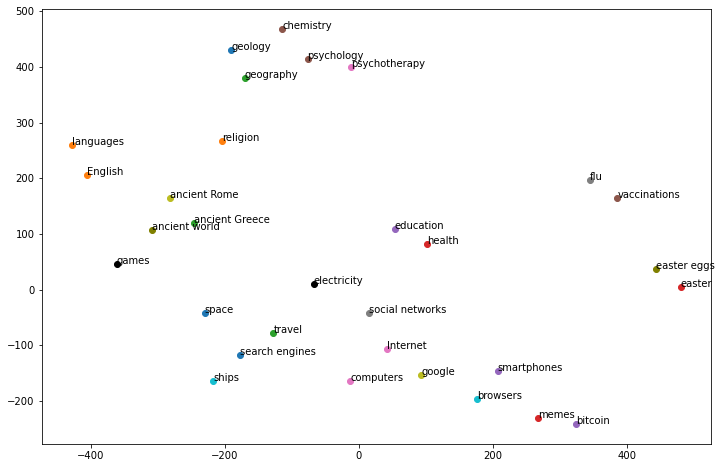

In [10]:
visualize(tsne_embeddings , words)

In [11]:
def visualize_clustering(embeddings , words , clusters):
    
    from collections import defaultdict
    
    fig , ax = plt.subplots(1, 1, figsize=(12,8))
    
    assert len(embeddings) == len(words)
    assert len(words) == len(clusters)
    
    grouper = defaultdict(list)
    
    for pt , word , label in zip(embeddings , words , clusters):
        grouper[label].append((pt , word))
    
    for label in grouper:
        pts , _ = zip(*grouper[label])
        pts = np.array(pts)
        ax.scatter(pts[:,0] , pts[:,1])
    
    for label in grouper:
        for pt,word in grouper[label]:
            ax.annotate(word , (pt[0] , pt[1]) , rotation = 30)

## Clustering
Trying Kmeans and Agglomorative Clustering and calculating clustering metrics for both.

Found K=12 as a good cutpoint for both methods.

In [12]:
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS

In [13]:
def debug_clustering(points):
    from sklearn.metrics import silhouette_score , davies_bouldin_score
    ks  = []
    kmeans_silhouettes , kmeans_dunn = [] , [] 
    agg_silhouettes , agg_dunn = [] , [] 
    for k in range(2 , 30):
        ks.append(k)

        kmeans = KMeans(n_clusters=k).fit(points)
        kmeans_silhouettes.append(silhouette_score(points , kmeans.labels_))
        kmeans_dunn.append(davies_bouldin_score(points , kmeans.labels_))
        
        agg = AgglomerativeClustering(n_clusters=k).fit(points)
        agg_silhouettes.append(silhouette_score(points , agg.labels_))
        agg_dunn.append(davies_bouldin_score(points , agg.labels_))
        
    df = pd.DataFrame({
        "K" : ks , 
        "kmeans_silhouettes" : kmeans_silhouettes,
        "kmeans_dunn" : kmeans_dunn,
        "agg_silhouettes": agg_silhouettes,
        "agg_dunn": agg_dunn
    })
    display(df)

debug_clustering(X)

,K,kmeans_silhouettes,kmeans_dunn,agg_silhouettes,agg_dunn
0,2,0.090615,2.184186,0.076467,2.512783
1,3,0.102007,2.265397,0.092538,2.295407
2,4,0.100709,2.113574,0.108083,2.082143
3,5,0.107270,1.911081,0.116088,1.795472
4,6,0.122022,1.728074,0.121050,1.699901
5,7,0.125702,1.603102,0.135615,1.570495
6,8,0.135468,1.525343,0.157370,1.444044
7,9,0.139770,1.347003,0.166725,1.379397
8,10,0.164869,1.227978,0.167275,1.266932
9,11,0.149945,1.274582,0.170673,1.133480


## Fitting Both clustering methods on K=12

In [14]:
kmeans = KMeans(n_clusters=12).fit(X)
kmeans_labels = kmeans.labels_

agglomorative = AgglomerativeClustering(n_clusters=12).fit(X)
agglomorative_labels = agglomorative.labels_


optics = OPTICS(min_samples=2 , metric = "euclidean").fit(X)
optics_labels = optics.labels_

## PCA + Kmeans

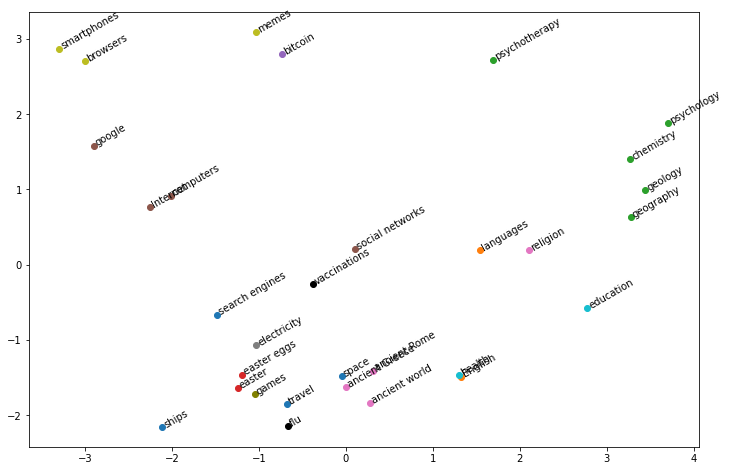

In [15]:
visualize_clustering(pca_embeddings , words , kmeans_labels)

## PCA + Agglomorative

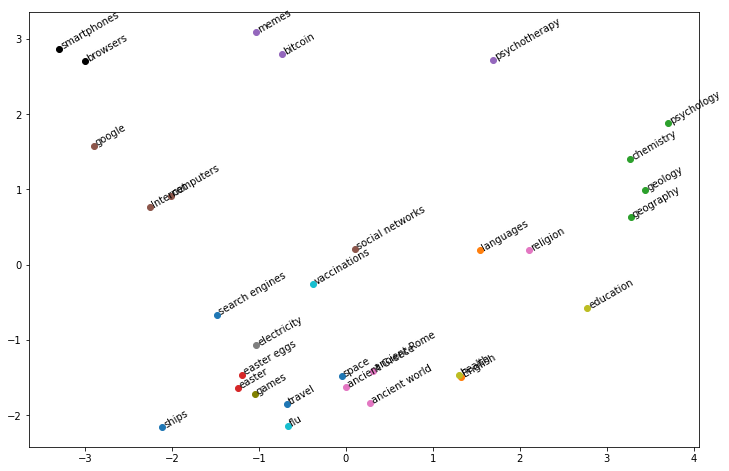

In [16]:
visualize_clustering(pca_embeddings , words , agglomorative_labels)

## PCA + OPTICS

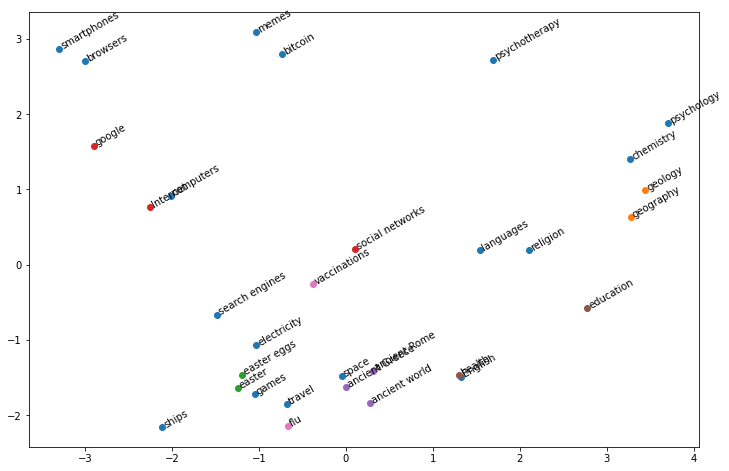

In [17]:
visualize_clustering(pca_embeddings , words , optics_labels)


## TSNE + Kmeans

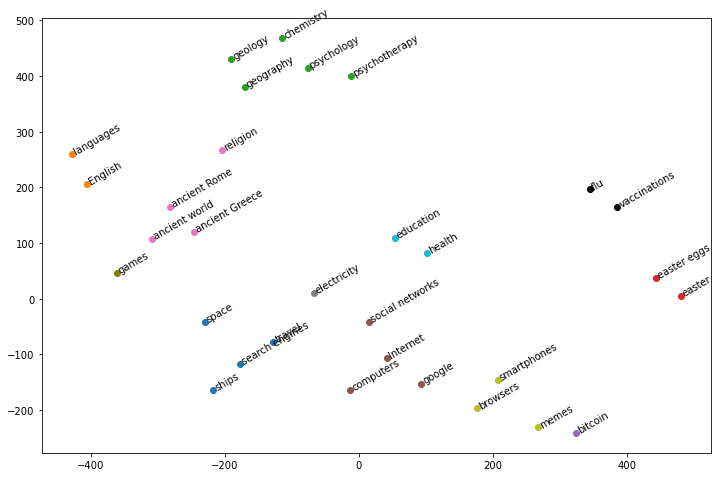

In [18]:
visualize_clustering(tsne_embeddings , words , kmeans_labels)

## TSNE + Agglomorative

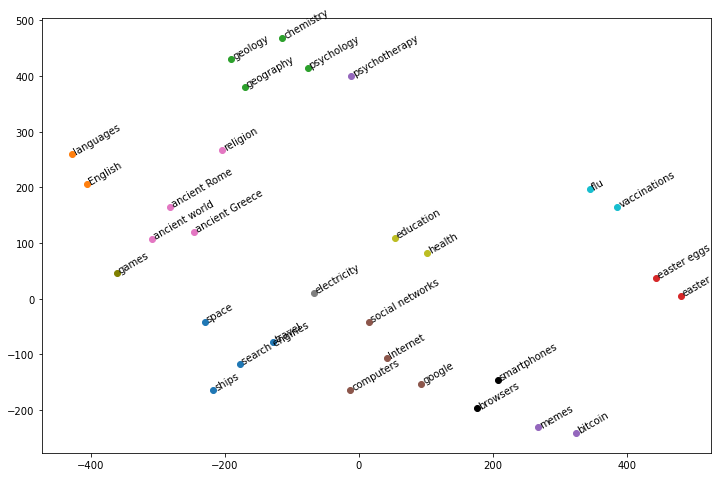

In [19]:
visualize_clustering(tsne_embeddings , words , agglomorative_labels)

## TSNE + Optics 

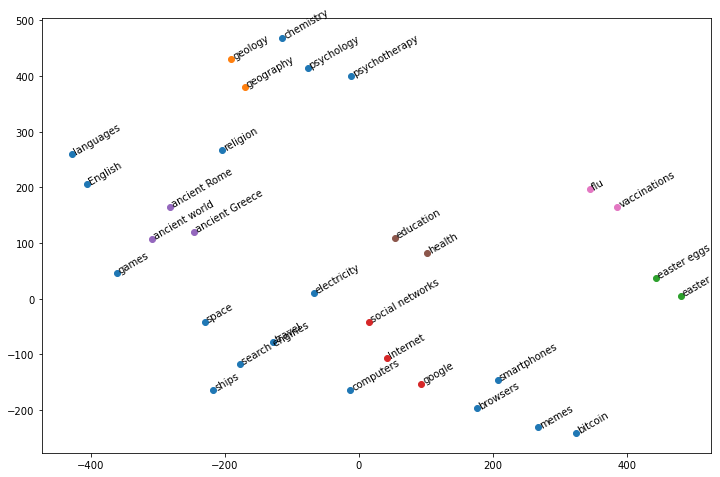

In [20]:
visualize_clustering(tsne_embeddings , words , optics_labels)

In [21]:
def clustering_report(points , words , labels, all_embeddings):
    from collections import defaultdict
    
    grouper = defaultdict(list)
    
    for pt , word , label in zip(points , words , labels):
        grouper[label].append((pt , word))
    
    for label in sorted(grouper.keys()):
        print("Cluster with label {}".format(label))
        
        points , words = zip(*grouper[label])
        points = np.array(points)
        stacked = np.vstack(points)
        
        center = np.mean(stacked , axis = 0)
        
        # I removed this because too much
        #print("Average vector (centroid) :: {}".format(center))
        
        distances = []
        for word , vec in all_embeddings.items():
            distances.append( (np.linalg.norm(vec - center) , word) )
        closest = min(distances , key = lambda x : x[0])
    
        print("Closest word from the embeddings model vocab :: {}".format(closest[1]))
                              
        print("Words inside this cluster :: {}".format(words))    
        
        var = sum([np.linalg.norm(vec - center) ** 2 for vec in points]) / points.shape[0]
        print("Within Cluster Variance :: {}".format(var))
            
        print("")

## Clustering report for kmeans

In [22]:
clustering_report(X , words , kmeans_labels, embeddings)

Cluster with label 0
Closest word from the embeddings model vocab :: travel
Words inside this cluster :: ('space', 'ships', 'travel', 'search engines')
Within Cluster Variance :: 12.766915069994624

Cluster with label 1
Closest word from the embeddings model vocab :: psychology
Words inside this cluster :: ('geography', 'chemistry', 'geology', 'psychology', 'psychotherapy')
Within Cluster Variance :: 12.385014183489286

Cluster with label 2
Closest word from the embeddings model vocab :: easter
Words inside this cluster :: ('easter', 'easter eggs')
Within Cluster Variance :: 2.7380263621705936

Cluster with label 3
Closest word from the embeddings model vocab :: browsers
Words inside this cluster :: ('memes', 'browsers', 'smartphones')
Within Cluster Variance :: 9.631797501533866

Cluster with label 4
Closest word from the embeddings model vocab :: internet
Words inside this cluster :: ('Internet', 'social networks', 'computers', 'google')
Within Cluster Variance :: 10.195994820843294
